# Generative Adversarial Network Tutorial 00

In this tutorial, we'll transform digits from one type to another with a deep neural network.  This is much more similar to the tasks we need to perform in physics (make simulation look like data), so it's more on point to that task.

Additionally, there is the added bonus of classifying the transformed digits.  We should be able to fool not just a generic discriminator, but if we tranform 3 into 8, it should get classified as 8.

## MNIST data set

In this tutorial, we still want to use the mnist digits, but we also want to keep track of the labels.  Since we'll be doing classification AND discrimination of real/fake, we'll want to have the one-hot labels this time.

In [1]:
%env CUDA_DEVICE_ORDER=PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES=2
import tensorflow as tf
import numpy
from tensorflow.examples.tutorials.mnist import input_data

env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=2


With tensorflow, you can specify which device to use.  The next cell will tell you what's available, and you can select from there.  By default, I select "/gpu:0" but you can change this below

In [2]:
from tensorflow.python.client import device_lib
print device_lib.list_local_devices()
default_device = "/gpu:0"

[name: "/cpu:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 17578764505616291766
, name: "/gpu:0"
device_type: "GPU"
memory_limit: 11990623847
locality {
  bus_id: 1
}
incarnation: 13103216971126205142
physical_device_desc: "device: 0, name: TITAN X (Pascal), pci bus id: 0000:03:00.0"
]


To make this a little nicer, I have a class that embeds images into 32x32 array with a random offset.  Setting one hot to true this time ...

In [3]:
class mnist_helper(object):
  """docstring for mnist_helper"""
  def __init__(self):
    super(mnist_helper, self).__init__()
    self.mnist = input_data.read_data_sets('MNIST_data', one_hot=True)
        

  def next_multi_image_train(self, batch_size=16, return_labels=True):
      # Build mnist images, each embedded into a 32x32 space
      # instead of 28x28
      batch, labels = self.mnist.train.next_batch(batch_size)
      # build an output data container:
      output = numpy.zeros((batch_size, 32, 32)) - 1
      # Copy images to output:
      image = 0
      for i in xrange(batch_size):
          x_start = numpy.random.randint(4)
          y_start = numpy.random.randint(4)
          output[i,x_start:x_start+28, y_start:y_start+28] = 2*(batch[image].reshape((28,28))) -1
          image+= 1
      if return_labels:
        return numpy.reshape(output, [batch_size, 32, 32, 1]), labels
      else:            
        return numpy.reshape(output, [batch_size, 32, 32, 1])

In [4]:
data_fetcher = mnist_helper()
mnist_images, mnist_labels = data_fetcher.next_multi_image_train(batch_size=5)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


Here, we've loaded the mnist data from the tensorflow helper class, and asked for the next batch of images and labels.  Let's view those to see what the data looks like before delving into the network:

In [5]:
print "mnist_images.shape: {}".format(mnist_images.shape)
print "mnist_labels.shape: {}".format(mnist_labels.shape)

mnist_images.shape: (5, 32, 32, 1)
mnist_labels.shape: (5, 10)


As expected, variables are arrays with the outermost dimension equal to 5.  The images, though, comes unpacked as a 1D array per image instead of a 2D array.  We can reshape this to what we're more familar with, since we know mnist images are 28x28:

In [6]:
print "mnist_images.shape: {}".format(mnist_images.shape)


mnist_images.shape: (5, 32, 32, 1)


Matplotlib gives a good interface for viewing these images in a notebook (or even in general, in python):

In [7]:
from matplotlib import pyplot as plt
%matplotlib inline

This image is labeled as [ 0.  0.  0.  0.  0.  0.  0.  0.  1.  0.]


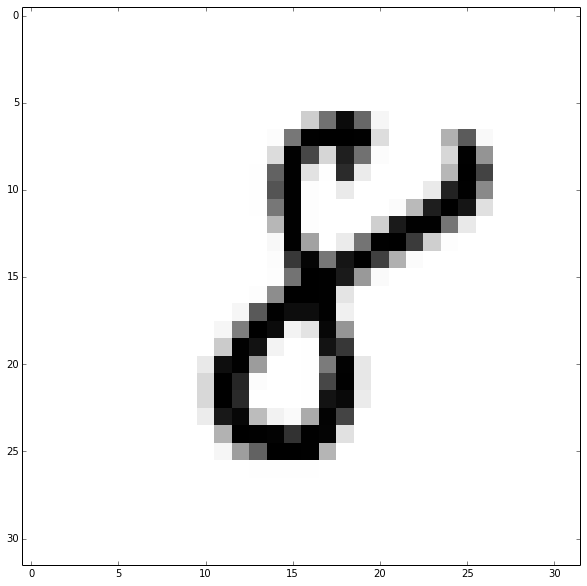

In [8]:
index = numpy.random.randint(5)
fig = plt.figure(figsize=(10,10))
plt.imshow(mnist_images[index,:,:,0], cmap="Greys", interpolation="none")
print "This image is labeled as {}".format(mnist_labels[index])
plt.show()

Drawn like this, you can see each individual pixel clearly.  It's not a high resolution image, but you can clearly tell what the digit is!

## Swapping labels

I think the easiest first task in this problem is to make careful swaps of the labels in a deterministic way.  Specifically:

* 0 &rightarrow; 6
* 1 &rightarrow; 7
* 2 &rightarrow; 5
* 3 &rightarrow; 8
* 4 &rightarrow; 9
* 5 &rightarrow; 2
* 6 &rightarrow; 0
* 7 &rightarrow; 1
* 8 &rightarrow; 3
* 9 &rightarrow; 4

Notice that these are closed cycles: each digit, if permuted twice, ought to map back to the original digit.  We can directly specify the permutation such that numpy can permute the digits for us:

In [9]:
permutation= numpy.array( [6, 7, 5, 8, 9, 2, 0, 1, 3, 4])

Let's verify we can do the permutation with the one hot tensors.  First we will collapse them into flat label list:

In [10]:
mnist_images, mnist_labels = data_fetcher.next_multi_image_train(batch_size=5)

In [11]:
def permute_labels(labels, one_hot=True):
    if not one_hot:
        output = numpy.ndarray(labels.shape, dtype=int)
        for i in xrange(len(permutation)):
            p = permutation[i]
            output[numpy.where(labels==i)] = int(p)
        return output
    else:
        output = numpy.zeros(labels.shape)
        flattened_labels = numpy.argmax(labels, axis=-1)
        permuted_labels = permute_labels(flattened_labels, one_hot=False)
        for i in xrange(len(permuted_labels)):
            output[i,permuted_labels[i]] = 1
        return output


In [12]:
print "Original labels:\n{}".format(mnist_labels)
mnist_flattened = numpy.argmax(mnist_labels, axis=-1)
print mnist_flattened

Original labels:
[[ 0.  0.  0.  0.  0.  0.  0.  1.  0.  0.]
 [ 0.  0.  1.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  1.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  1.]
 [ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.]]
[7 2 8 9 0]


In [13]:
permute_labels(mnist_flattened, False)

array([1, 5, 3, 4, 6])

In [14]:
permute_labels(mnist_labels)

array([[ 0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.]])

## Building a model for a GAN

We'll start to put together a network for the GAN, first by defining some useful constants that we'll need to call on multiple times:

In [15]:
BASE_LEARNING_RATE = 0.00001
BATCH_SIZE=50 # Keep this even
DISCRIMINATOR_WEIGHT = 1.0
CLASSIFIER_WEIGHT = 1.0
RESTORE=False
ADD_OUTPUT_NOISE=True
N_PRETRAIN_ITERATIONS=5000
LOGDIR="./mnist_trans_logs/output_noise_{}".format(ADD_OUTPUT_NOISE)
TRAINING=True

Additionally, let's make sure we have the same graph by defining it:

In [16]:
tf.reset_default_graph()
g = tf.Graph()

Set up the placeholders for the input variables.  We'll need to input both real image, labels and random noise, so make a placeholder for everything:

In [17]:
with tf.device(default_device):
    with g.as_default():

        # Placeholder for the real input images:
        real_images_input  = tf.placeholder(tf.float32, (None, 32, 32, 1), name="real_images_input")
        # Placeholder for the real labels:
        real_labels  = tf.placeholder(tf.float32, [None, 10], name="real_labels")
   
        # Placeholder for images that are going to be transformed
        pre_trans_images  = tf.placeholder(tf.float32, (None, 32, 32, 1), name="pre_trans_images")
        # Placeholder for the transformed labels:
        trans_labels = tf.placeholder(tf.float32, [None, 10], name="trans_labels")
           

        # We augment the input to the discriminator with gaussian noise
        # This makes it harder for the discriminator to do it's job, preventing
        # it from always "winning" the GAN min/max contest
        real_noise  = tf.placeholder(tf.float32, [None, 32, 32, 1], name="real_noise")
        trans_noise = tf.placeholder(tf.float32, [None, 32, 32, 1], name="fake_noise")

        # Add the noise to the real images:
        real_images = real_images_input + real_noise
        # trans_noise gets added later
        
        # To skip noise addition, we just feed in 0s at training time.


Now we can define the networks.  In this case, there are 3: a transformer, a discriminator, and a classifier.  We will do the transformer first.

### Image Transformer:

Now we can define a function to transform images into new images.  This will be a residual network that is connected across spatial maps (U-ResNet, essentially).  It will return in the end a tensor of (B, 32, 32, 1) that matches the input shape. I'm not sure if it's better to use that directly as the created digits, or as a residual.

Some notes on the network here:
* Let's do this as a residual network
* Each step of the network in downsampling will include a residual block and then a downsampling block
* Downsampling will be done with strided convolutions
* Upsampling will be a transpose convolution and then a residual block
* The filters of each downsampling block (just before downsampling) will be concatenated with the filters of each upsampling block, just before the residual block

Below, I define a residual block function, an upsample and a downsample block function.  These are reusable in the discriminator, transformer, and classifier.
        

In [18]:
def residual_block(input_tensor,
                   is_training,
                   kernel=[3, 3],
                   stride=[1, 1],
                   name="",
                   reuse=False):
    """
    @brief      Create a residual block and apply it to the input tensor

    @param      input_tensor  The input tensor
    @param      kernel        Size of convolutional kernel to apply
    @param      n_filters     Number of output filters

    @return     { Tensor with the residual network applied }
    """

    # Residual block has the identity path summed with the output of
    # BN/Relu/Conv2d applied twice

    # Assuming channels last here:
    n_filters = input_tensor.shape[-1]

    with tf.variable_scope(name + "_0"):
        # Batch normalization is applied first:
        x = tf.layers.batch_normalization(input_tensor,
                                          axis=-1,
                                          training=is_training,
                                          trainable=True,
                                          name="BatchNorm",
                                          reuse=reuse)


        # Conv2d:
        x = tf.layers.conv2d(x, n_filters,
                             kernel_size=kernel,
                             strides=stride,
                             padding='same',
                             trainable=is_training,
                             name="Conv2D",
                             reuse=reuse)
        # ReLU:
        x = tf.nn.relu(x)
        
    # Apply everything a second time:
    with tf.variable_scope(name + "_1"):

        # Batch normalization is applied first:
        x = tf.layers.batch_normalization(x,
                                          axis=-1,
                                          training=is_training,
                                          trainable=True,
                                          name="BatchNorm",
                                          reuse=reuse)

        # Conv2d:
        x = tf.layers.conv2d(x,
                             n_filters,
                             kernel_size=kernel,
                             strides=stride,
                             padding='same',
                             trainable=is_training,
                             name="Conv2D",
                             reuse=reuse)

    # Sum the input and the output:
    with tf.variable_scope(name+"_addition"):
        x = tf.add(x, input_tensor, name="Add")
        x = tf.nn.relu(x)
    return x



In [19]:
def downsample_block(input_tensor,
                     is_training,
                     kernel=[3, 3],
                     name="",
                     increase_filters=True,
                     reuse = False):
    """
    @brief      Create a residual block and apply it to the input tensor

    @param      input_tensor  The input tensor
    @param      kernel        Size of convolutional kernel to apply
    @param      n_filters     Number of output filters

    @return     { Tensor with the residual network applied }
    """

    # Residual block has the identity path summed with the output of
    # BN/Relu/Conv2d applied twice

    # Assuming channels last here:
    if not increase_filters:
        n_filters = input_tensor.get_shape().as_list()[-1]
    else:
        n_filters = 2*input_tensor.get_shape().as_list()[-1]

    with tf.variable_scope(name + "_0"):
        # Batch normalization is applied first:
        x = tf.layers.batch_normalization(input_tensor,
                                          training=is_training,
                                          trainable=True,
                                          name="BatchNorm",
                                          reuse=reuse)


        # Conv2d:
        x = tf.layers.conv2d(x, n_filters,
                             kernel_size=kernel,
                             strides=[2, 2],
                             padding='same',
                             trainable=is_training,
                             name="Conv2D",
                             reuse=reuse)

        # ReLU:
        x = tf.nn.relu(x)

    return x

In [20]:
def upsample_block(input_tensor,
                   is_training,
                   kernel=[3, 3],
                   alpha = 0.0,
                   name=""):
    """
    @brief      Create a residual block and apply it to the input tensor

    @param      input_tensor  The input tensor
    @param      kernel        Size of convolutional kernel to apply
    @param      n_filters     Number of output filters

    @return     { Tensor with the residual network applied }
    """

    # Residual block has the identity path summed with the output of
    # BN/Relu/Conv2d applied twice

    # Assuming channels last here:
    n_filters = int(0.5*input_tensor.get_shape().as_list()[-1])
    # Prevent attempts to produce no filters at the next stage up:
    if n_filters == 0:
        n_filters = 1

    with tf.variable_scope(name + "_0"):
        # Batch normalization is applied first:
        x = tf.layers.batch_normalization(input_tensor,
                                          training=is_training,
                                          trainable=True,
                                          name="BatchNorm",
                                          reuse=None)

        # Conv2d:
        x = tf.layers.conv2d_transpose(x, n_filters,
                             kernel_size=kernel,
                             strides=[2, 2],
                             padding='same',
                             trainable=True,
                             name="Conv2DTrans",
                             reuse=None)
        # ReLU:
        x = tf.nn.relu(x)

    return x

In [21]:
def build_transformer(input_tensor, n_initial_filters=32, is_training=True):
    # Again, scoping is essential here:
    with tf.variable_scope("mnist_transformer"):
       

        # To make this code cleaner, the upsampling, downsampling, and residual block steps have all be 
        # written as functions above.
        
        # Map the input tensor with an intial convolution:
        x = tf.layers.batch_normalization(input_tensor,
                                          training=is_training,
                                          trainable=True,
                                          name="BatchNormInitial",
                                          reuse=None)
        
        x = tf.layers.conv2d(x, n_initial_filters, 
                            kernel_size=[5,5],
                            strides=[1,1],
                            padding="same",
                            trainable=True,
                            name="InitialConv2D")
        
        # Apply a series of downsampling blocks to take the spatial dimensions down as follows:
        # (B, 32, 32, n_initial_filters)
        # (B, 16, 16, 2*n_initial_filters)
        # (B, 8, 8, 4*n_initial_filters)
        # (B, 4, 4, 8*n_initial_filters)
        # After each residual block, store the output to connect to the upsampling block
        
        feature_maps=dict()
        for i in [32, 16, 8, 4]:
            x = residual_block(x,
                               is_training,
                               name="residual_block_down_{}".format(i))
            feature_maps[i] = x
            # Downsample:
            x = downsample_block(x, is_training,
                                name="downsample_block_{}".format(i))

            
        # Now at the bottom of the network, apply a residual block:
        x = residual_block(x, is_training,
                           name="residual_block_bottom")
        
        # Begin to upsample the network:
        for i in [4, 8, 16, 32]:
            x = upsample_block(x, is_training,
                               name="upsample_block_{}".format(i))
            
            
            n_filters = x.get_shape().as_list()[-1]
            
            # Concatenate the appropriate filters:
            x = tf.concat([x, feature_maps[i]], -1)
            
            # Apply a 1x1 filter to preserve the number of filters:
            x = tf.layers.conv2d(x, n_filters,
                                 kernel_size=[1,1],
                                 strides=[1,1],
                                 name ="bottleneck_up_{}".format(i))
            
            # Apply a residual block:
            x = residual_block(x,
                               is_training,
                               name="residual_block_up_{}".format(i))
            
        # Finally, we apply a bottleneck to map the tensors to a (B, 32, 32, 1) shaped output:
        x = tf.layers.conv2d(x, 1,
                             kernel_size=[1,1],
                             strides=[1,1],
                             name ="FinalBottleneck")

        # Final activation is tanh
        x = tf.nn.tanh(x)
        return x

In [22]:
with tf.device(default_device):
    with g.as_default():
        transformed_images = build_transformer(pre_trans_images, is_training=TRAINING)
        transformed_images = transformed_images + trans_noise

### Image Classifier and Discriminator

The next network will take the images, either real or transformed, and classify them into what digit they are.  We'll use the same weights for the real and transformed classifier, and the architecture will be similar to the downsample path of the transformer network.  The output here will contain one extra digit that will go to a sigmoid, not a softmax, to classify as real or not real (transformed).

In [23]:
def build_classifier(input_tensor, n_initial_filters=16, is_training=True, reuse=False):
    # Again, scoping is essential here:
    with tf.variable_scope("mnist_classifier", reuse=reuse):
       

        # To make this code cleaner, the upsampling, downsampling, and residual block steps have all be 
        # written as functions above.
        
        # Map the input tensor with an intial convolution:
        x = tf.layers.batch_normalization(input_tensor,
                                          training=is_training,
                                          trainable=True,
                                          name="BatchNormInitial")
        
        x = tf.layers.conv2d(x, n_initial_filters, 
                            kernel_size=[5,5],
                            strides=[1,1],
                            padding="same",
                            trainable=True,
                            name="InitialConv2D")
        
        # Apply a series of downsampling blocks to take the spatial dimensions down as follows:
        # (B, 32, 32, n_initial_filters)
        # (B, 16, 16, 2*n_initial_filters)
        # (B, 8, 8, 4*n_initial_filters)
        # (B, 4, 4, 8*n_initial_filters)
        # (B, 4, 4, 10) # Preparation for global average pooling
        # After each residual block, store the output to connect to the upsampling block
        
        for i in [32, 16, 8, 4]:
            x = residual_block(x,
                               is_training,
                               name="residual_block_down_{}".format(i))
            # Downsample:
            if i != 4:
                x = downsample_block(x, is_training,
                                    name="downsample_block_{}".format(i))


        x = residual_block(x, is_training,
                          name = "final_residual_block")
            
        # Finally, we apply a bottleneck to map the tensors to a (B, 4, 4, 11) shaped output:
        x = tf.layers.conv2d(x, 11,
                             kernel_size=[1,1],
                             strides=[1,1],
                             name ="FinalBottleneck")
        
        # Apply Global Average pooling:
        x = tf.layers.average_pooling2d(x,
                                        pool_size=[4,4],
                                        strides=[1,1])

        x = tf.reshape(x, [-1, 11])
        
        classification, discrimination = tf.split(x, [10,1], -1)
        # For classification, final activation is softmax:
        classification = tf.nn.softmax(classification)
        discrimination = tf.nn.sigmoid(discrimination)
        return classification, discrimination

In [24]:
print real_images.get_shape()
print transformed_images.get_shape()

(?, 32, 32, 1)
(?, 32, 32, 1)


In [25]:
with tf.device(default_device):
    with g.as_default():
        real_image_classification, real_image_discrimination = build_classifier(real_images, is_training=TRAINING) 
        trans_image_classification, trans_image_discrimination = build_classifier(transformed_images, 
                                                                                  reuse = True, 
                                                                                  is_training=TRAINING)

In [26]:
print real_image_classification.get_shape()
print real_image_discrimination.get_shape()

(?, 10)
(?, 1)


#### Network model summary

There is a good amount of code happening above.  To summarize it, we have two sets of real input images and real labels.  On one path, we take a set of real images and ask the transformer network to turn them into alternate digits according to the permutation above.  On the other path, we do nothing to the input images. 

The Adversarial network does two tasks with the same network: decide if an image is real or transformed, and classify the image to a digit.

### Loss functions

We can now define our loss functions.  Note that we have to define the loss function for the real and transformed data seperately:

In [27]:
with tf.device(default_device):
    # Build the loss functions:
    with g.as_default():
        with tf.name_scope("cross_entropy") as scope:

            #########################################################################
            # Build the loss functions for the discriminator first:
            #########################################################################
            
            # Discriminator loss on real images (classify as 1):
            d_loss_real = tf.reduce_mean(
                tf.nn.sigmoid_cross_entropy_with_logits(logits=real_image_discrimination,
                                                        labels = tf.ones_like(real_image_discrimination)))
            #Discriminator loss on transformed images (classify as 0):
            d_loss_trans = tf.reduce_mean(
                tf.nn.sigmoid_cross_entropy_with_logits(logits=trans_image_discrimination,
                                                        labels = tf.zeros_like(trans_image_discrimination)))

            # Total discriminator loss is the sum:
            d_loss = d_loss_real + d_loss_trans

            #########################################################################
            # Build a loss function for the transformer to be incorrectly classifier:
            #########################################################################
            
            t_loss = tf.reduce_mean(
                tf.nn.sigmoid_cross_entropy_with_logits(logits=trans_image_discrimination,
                                                        labels = tf.ones_like(trans_image_discrimination)))

            #########################################################################
            # Build a loss function for the classifier for real and fake data:
            #########################################################################

            c_loss_real  = tf.reduce_mean(
                tf.nn.softmax_cross_entropy_with_logits(logits=real_image_classification,
                                                        labels=real_labels))
            
            c_loss_trans =tf.reduce_mean(
                tf.nn.softmax_cross_entropy_with_logits(logits=trans_image_classification,
                                                        labels=trans_labels))
            
            # We don't define a classifier total loss here.  Instead, we'll train the
            # classifier on real digits only, and use the trained classifer to 
            # drive the transformer
            
            t_loss_total = DISCRIMINATOR_WEIGHT*t_loss + CLASSIFIER_WEIGHT*c_loss_trans
            d_loss_total = DISCRIMINATOR_WEIGHT*d_loss + CLASSIFIER_WEIGHT*c_loss_real
            
            # This code is useful if you'll use tensorboard to monitor training:
            tf.summary.scalar("Discriminator_Real_Loss", d_loss_real)
            tf.summary.scalar("Discriminator_Trans_Loss", d_loss_trans)
            tf.summary.scalar("Discriminator_Total_Loss", d_loss)
            tf.summary.scalar("Transformer_Loss", t_loss)
            tf.summary.scalar("Classifier_Real_Loss", c_loss_real)
            tf.summary.scalar("Classifier_Trans_Loss", c_loss_trans)
            tf.summary.scalar("TransformerOptimizedLoss",t_loss_total)
            tf.summary.scalar("AdversaryOptimizedLoss",d_loss_total)
            

It's also useful to compute accuracy, just to see how the training is going:

In [28]:
with tf.device(default_device):
    with g.as_default():
        with tf.name_scope("accuracy") as scope:
            # Compute the discriminator accuracy on real data, fake data, and total:
            d_accuracy_real   = tf.reduce_mean(tf.cast(tf.equal(tf.round(real_image_discrimination), 
                                                             tf.ones_like(real_image_discrimination)), 
                                                    tf.float32))
            d_accuracy_trans  = tf.reduce_mean(tf.cast(tf.equal(tf.round(trans_image_discrimination), 
                                                             tf.zeros_like(trans_image_discrimination)), 
                                                    tf.float32))

            d_total_accuracy  = 0.5*(d_accuracy_trans +  d_accuracy_real)

            c_accuracy_real = tf.reduce_mean(
                tf.cast(tf.equal(tf.argmax(real_image_classification), 
                                 tf.argmax(real_labels)), 
                        tf.float32))
            
            c_accuracy_trans = tf.reduce_mean(
                tf.cast(tf.equal(tf.argmax(trans_image_classification), 
                                 tf.argmax(trans_labels)), 
                        tf.float32))
            
            # Again, useful for tensorboard:
            tf.summary.scalar("Discriminator_Real_Accuracy", d_accuracy_real)
            tf.summary.scalar("Discriminator_Trans_Accuracy", d_accuracy_trans)
            tf.summary.scalar("Discriminator_Total_Accuracy", d_total_accuracy)
            tf.summary.scalar("Classifier_Real_Accuracy", c_accuracy_real)
            tf.summary.scalar("Classifier_Trans_Accuracy", c_accuracy_trans)


### Independant Optimizers

To allow the generator and discriminator to compete and update seperately, we use two distinct optimizers.  This step is why it was essential earlier to have the scopes different for the generator and optimizer: we can select all variables in each scope to go to their own optimizer.  So, even though the generator loss calculation runs the discriminator, the update step for the generator **only** affects the variables inside the generator

In [29]:
with tf.device(default_device):
    with g.as_default():
        with tf.name_scope("training") as scope:
            # Global steps are useful for restoring training:
            global_step = tf.Variable(0, dtype=tf.int32, trainable=False, name='global_step')

            # Make sure the optimizers are only operating on their own variables:

            all_variables      = tf.trainable_variables()
            generator_vars     = [v for v in all_variables if v.name.startswith('mnist_transformer/')]
            classifier_vars     = [v for v in all_variables if v.name.startswith('mnist_classifier/')]

            
            transformer_optimizer   = tf.train.AdamOptimizer(BASE_LEARNING_RATE, 0.5).minimize(
                t_loss_total, global_step=global_step, var_list=generator_vars)
            classifier_optimizer    = tf.train.AdamOptimizer(BASE_LEARNING_RATE, 0.5).minimize(
                d_loss_total, global_step=global_step, var_list=classifier_vars)

            # This optimizer is for pretraining the classification task:
            pretrain_class_optimizer = tf.train.AdamOptimizer(10*BASE_LEARNING_RATE).minimize(
                c_loss_real, global_step=global_step, var_list=classifier_vars)
            
             

### Image snapshots

It's useful to snapshot images into tensorboard to see how things are going, as well:

In [30]:
with tf.device(default_device):
    with g.as_default():
        tf.summary.image('trans_images', transformed_images, max_outputs=4)
        tf.summary.image('real_images', real_images, max_outputs=4)


## Training the networks

There are lots of philosophys on training GANs.  Here, we'll do something simple and just alternate updates. To save the network and keep track of training variables, set up a summary writer:

In [33]:
with tf.device(default_device):
    with g.as_default():
        merged_summary = tf.summary.merge_all()

        # Set up a saver:
        train_writer = tf.summary.FileWriter(LOGDIR)

Set up a session for training using an interactive session:

In [ ]:
if TRAINING:
    with tf.device(default_device):
        with g.as_default():
            sess = tf.InteractiveSession()
            if not RESTORE:
                sess.run(tf.global_variables_initializer())
                train_writer.add_graph(sess.graph)
                saver = tf.train.Saver()
            else: 
                latest_checkpoint = tf.train.latest_checkpoint(LOGDIR+"/checkpoints/")
                print "Restoring model from {}".format(latest_checkpoint)
                saver = tf.train.Saver()
                saver.restore(sess, latest_checkpoint)


            data_fetcher = mnist_helper()

            print "Begin training ..."
            # Run training loop
            for i in xrange(50000):
                step = sess.run(global_step)


                # As a reminder, here are the variables we need to supply values for:

                #######################################################################################
                ##  # Placeholder for the real input images:
                ##  real_images_input  = tf.placeholder(tf.float32, (None, 32, 32, 1))
                ##  # Placeholder for the real labels:
                ##  real_labels  = tf.placeholder(tf.float32, [None, 10])
                ##  
                ##  # Placeholder for images that are going to be transformed
                ##  pre_trans_images  = tf.placeholder(tf.float32, (None, 32, 32, 1))
                ##  # Placeholder for the transformed labels:
                ##  trans_labels = tf.placeholder(tf.float32, [None, 10])
                ##  
                ##  
                ##  # We augment the input to the discriminator with gaussian noise
                ##  # This makes it harder for the discriminator to do it's job, preventing
                ##  # it from always "winning" the GAN min/max contest
                ##  real_noise  = tf.placeholder(tf.float32, [None, 32, 32, 1], name="real_noise")
                ##  trans_noise = tf.placeholder(tf.float32, [None, 32, 32, 1], name="fake_noise")
                #######################################################################################

                # Let's generate the noise tensors:

                sigma = max(0.25*(30000. - step) / (30000), 0.02)
                if ADD_OUTPUT_NOISE:
                    real_noise_addition = numpy.random.normal(scale=sigma,size=(int(BATCH_SIZE*0.5),32,32,1))
                    trans_noise_addition = numpy.random.normal(scale=sigma,size=(int(BATCH_SIZE*0.5),32,32,1))
                else:
                    real_noise_addition = numpy.zeros(shape=(int(BATCH_SIZE*0.5),32,32,1))
                    trans_noise_addition = numpy.zeros(shape=(int(BATCH_SIZE*0.5),32,32,1))

                # Get a set of real images and labels to transform:
                pre_transformed_images, pre_transformed_labels = data_fetcher.next_multi_image_train(int(BATCH_SIZE*0.5))
                # Get a set of real images and labels to do nothing to:
                not_transformed_images, not_transformed_labels = data_fetcher.next_multi_image_train(int(BATCH_SIZE*0.5))

                # Permute the labels that need to be permuted:
                transformed_labels = permute_labels(pre_transformed_labels, one_hot=True)

                # We have to update the discriminator, classifier, and generator.

                
                fd = {real_images_input : not_transformed_images,
                      real_labels       : not_transformed_labels,
                      pre_trans_images  : pre_transformed_images,
                      trans_labels      : transformed_labels,
                      real_noise        : real_noise_addition,
                      trans_noise       : trans_noise_addition}

                
                #Pretrain the classification network for a few iterations:
                if step < N_PRETRAIN_ITERATIONS: 
                    sess.run(pretrain_class_optimizer, feed_dict=fd)
                else:
                    sess.run(classifier_optimizer, feed_dict=fd)
                    
                # Update the transformer only after the pretraining:
                if step >= N_PRETRAIN_ITERATIONS:
                    sess.run(transformer_optimizer, feed_dict=fd)
                    
                summary = sess.run(merged_summary,feed_dict = fd)

                train_writer.add_summary(summary, step)


                if step != 0 and step % 500 == 0:
                    saver.save(
                        sess,
                        LOGDIR+"/checkpoints/save",
                        global_step=step)


                # train_writer.add_summary(summary, i)
                # sys.stdout.write('Training in progress @ step %d\n' % (step))
                if i % 150 == 0:
                    print 'Training in progress @ global_step %d,' % (step)


Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Begin training ...
Training in progress @ global_step 0,
Training in progress @ global_step 150,
Training in progress @ global_step 300,
Training in progress @ global_step 450,
Training in progress @ global_step 600,
Training in progress @ global_step 750,
Training in progress @ global_step 900,
Training in progress @ global_step 1050,
Training in progress @ global_step 1200,
Training in progress @ global_step 1350,
Training in progress @ global_step 1500,
Training in progress @ global_step 1650,
Training in progress @ global_step 1800,
Training in progress @ global_step 1950,
Training in progress @ global_step 2100,
Training in progress @ global_step 2250,
Training in progress @ global_step 2400,
Training in progress @ global_step 2550,
Training in progress @ global_step 2700,
Training in progr

Let's take a look at some of the output of the network to see the results:

In [ ]:
if not TRAINING:
    with tf.device(default_device):
        with g.as_default():
            sess = tf.InteractiveSession()
            latest_checkpoint = tf.train.latest_checkpoint(LOGDIR+"/checkpoints/")
            print "Restoring model from {}".format(latest_checkpoint)
            saver = tf.train.Saver()
            saver.restore(sess, latest_checkpoint)

            data_fetcher = mnist_helper()

            # For this, we want to be able to compare original to transformed images.  
            pre_transformed_images, pre_transformed_labels = data_fetcher.next_multi_image_train(int(BATCH_SIZE*0.5))


            # No need to add noise to the images, so pass in zeros for noise.
            real_noise_addition = numpy.zeros(shape=(int(BATCH_SIZE*0.5),32,32,1))
            trans_noise_addition = numpy.zeros(shape=(int(BATCH_SIZE*0.5),32,32,1))


            fd = {real_images_input : pre_transformed_images,
                  real_labels       : pre_transformed_labels,
                  pre_trans_images  : pre_transformed_images,
                  real_noise        : real_noise_addition,
                  trans_noise       : trans_noise_addition}


            [generated_images, real_class, trans_class] = sess.run(
                    [transformed_images, 
                     real_image_classification, 
                     trans_image_classification], 
                    feed_dict = fd)


Let's take a look at these images.  We will draw the original on the left and the transformed image on the right, as well as the labels for both 

In [ ]:
for i in xrange(len(generated_images)):
    original = pre_transformed_images[i].reshape((32,32))
    new_img = generated_images[i].reshape((32,32))
    f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(20, 10))
    ax1.imshow(original, cmap="Greys", interpolation="none")
    ax2.imshow(new_img, cmap="Greys", interpolation="none")
    plt.show()
    
    real_label = numpy.argmax(pre_transformed_labels[i])
    real_prob = real_class[i][real_label]
    selected_label = numpy.argmax(real_class[i])
    print "Original label is {}, selected label is {}, classification probability as {} is {}.".format(
        real_label, selected_label, real_label, real_prob )
    
    break
